# Pump it Up: Data Mining the Water Table
Using the from <a href='https://taarifa.org/'>Taarifa</a> and the <a href='https://www.maji.go.tz/'>Tanzanian Ministry of Water</a>, I create several models to predict which water pumps are functional or not. To simplify the process, I will only work with two prediction labels: functional and not functional, and will apply all the underlying processes from a Machine Learning (ML) workflow standpoint. It is also important to understand which metric we are going to maximize, given the nature of the problem. 

I start by introducing the problem, its stakeholders and why is it a relevant and what I am trying to achieve. Then I import the libraries that I am going to use - a combination of pandas and sklearn modules, and then I start basic exploratory data analysis (EDA) and cleaning processes.

From there, we prepare the date and use the training, testing splitting processes so I can inspect how the models will perform on both training and testing data. The notebook will provide three basic Machine Learning models and will also provide a workflow pipeline and a grid search alternative at the end.

Finally, I wrap up with the conclusion from this exercise and provide some recommendations about what I have discovered. Feel free to criticize, suggest improvements and interact. The dataset comes from DrivenData's Pump it Up: Data Mining the Water Table competition and can be found <a href='https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/'>here</a>.

## Business Problem
Impoverished countries have difficulties in having access to clean water. Water poverty is responsible for a series of illnesses. Anecdotal evidence from the <a href='https://www.tanzaniawaterproject.org/how-were-making-a-difference/water-as-a-word-health-issue/'>Tanzanian Water Project</a> lists that:
<ul>
    <li>1/6 of the world population lack access to safe water;</li>
    <li>88% of the diseases are caused by unsafe water drinking;</li>
    <li>The average American uses 100-175 gallon of water daily, whereas the average African uses 5 gallon of water daily;</li>
    <li>Water poverty negatively impacts education, local economies, agriculture and gender equality.</li>
</ul>
Furthermore, it is estimated that people living in water poverty struck places usually have to walk around 3-5 miles per day to have access to questionable water supply. 

Even though the provided analysis does not solves the issue of lacking water wells in impoverished regions, I posit that having access to the status of a functioning well has its benefits. By having a predictive analysis that shows whether a well is properly functioning or not, public policy efforts can be driven to: fix that well, assess the quality of that well, and provide a better service to communities that use those wells.

The stakeholders are the Tanzanian public policy makers and government, NGO's and the general public - not only the ones that use that well, but all the other communities and people interested. 

## Data Importing and Exploratory Data Analysis

I start by importing the libraries that are going to be used and inspect the DataFrames provided by DrivenData.

In [1]:
# Importing the libraries that are going to be used
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Importing the Datasets from the Tanzania Water Pumping Data Driven's website

# This DataFrame is for the Training Set Labels
df1 = pd.read_csv('csv/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

# This DataFrame is for the Test Set Values
df2 = pd.read_csv('csv/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

# This DataFrame is for the Training Set Values
df3 = pd.read_csv('csv/4910797b-ee55-40a7-8668-10efd5c1b960.csv')

# Inspecting df1 - Training Set Labels ('y_train')
df1.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [3]:
# Inspecting df2 - Test Set Values ('X_test'), these are the ones that need to be predicted
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [4]:
# Inspecting df3 - Training Set Values ('X_train')
df3.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
# I join the training labels with the 'X_train' dataframe. The motivation behind this procedure is to create a new
# data split, so I can evaluate the performance of the underlying models that I am going to use to predict the labels

df = df1.merge(df3, on = 'id', how = 'inner')


Overall, we have a combination of integer values and objects on the DataFrame's column. We will need to preprocess (i.e scaling) the numerical ones, whereas the categorical ones must pass through an encoding process. Furthermore, a lot of variables seem to be correlated - providing the same information through different features. Let's take as an example the geolocator variables (you can check the list of variables and their characteristics <a href='https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/'>here</a>) and some other features such as the type of extraction and so on.

Let's examine the number of columns with missing values as well.


In [6]:
# Checking the general features of the dataset - a lot of variables with similar names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

We can see there are a few missing rows, specially for scheme_name. Other variables with missing values are: funder, subvillage, public_meeting, scheme_management and permit. According to <a href='https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/'>Driven Data's website</a> the variables funder represents who funded the well, subvillage is a geolocation variable, public_meeting is a boolean value (True/False) which might indicate whether there are public meetings, scheme_name and scheme_management illustrates who operates the waterpoint and permit yields whether the point has a permit. 

I argue that subvillage can be dropped without any compromise to the analysis, given that we have other geolocation variables that might be correlated with subvillage. The variables scheme_name and scheme_management are also correlated, since both indicate who operates the waterpoint - so I drop the one with fewer entries (scheme_name).

The other variables are kept, since there isn't a huge loss to the number of rows.


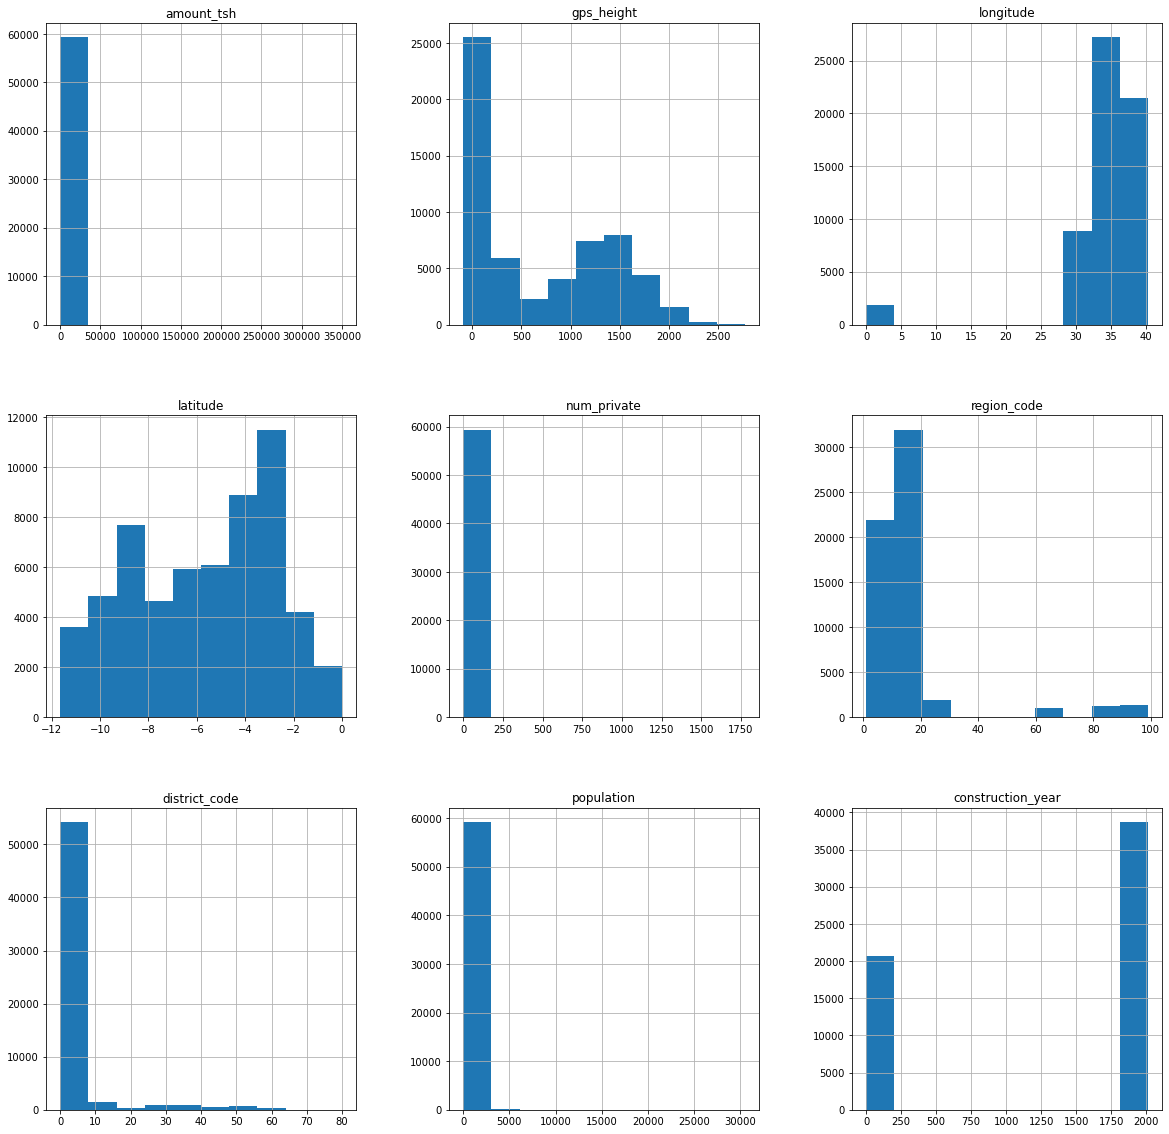

In [7]:
# Setting the DataFrame index
df = df.set_index('id')

# Plotting an histogram
ax = df.hist(figsize = (20, 20))
plt.show()

### Distribution of numerical features
By plotting an histogram of our DataFrame, we can visually inspect the general characteristics of our numerical variables. Clearly, id can be disregarded - since it is only an index. So let's take a look at the other ones.

<ul>
    <li><b>amount_tsh</b>: the amount of water available is centered around zero;</li>
    <li><b>gps_height</b>: is skewed, having most of its values around zero as well;</li>
    <li><b>latitude and longitude</b>: even though these variables can work as locators, we also have other categorical features that might provide the same 'information', such as <b>'region_code'</b> and <b>'district_code'</b>. Both of these variables can be encoded as dummy variables;</li>
    <li><b>num_private</b> and <b>population</b>: variables with a lot of zero values, highly skewed and fairly unbalanced;</li>
    <li><b>construction_year</b>: skewed, but can be encoded as dummy variables as well.</li>
</ul>

### Variable overlap
Next I check variables with similar name's characteristics. That is, do they provide some overlapping values? From here, I start digging deeper into each of those features.

In [8]:
# Checking quantity and quantity group - they're all the same
print('Checking quantity and quantity_group overlap: \n',(df['quantity'] == df['quantity_group']).value_counts())
print('\n')

# Checking waterpoint_type and waterpoint_type_group - they're almost all the same, however there is a small
# number of entries that are different (~10%) - I will drop it since it won't provide much difference to the models
print('Checking waterpoint_type and waterpoint_type overlap: \n',(df['waterpoint_type'] == df['waterpoint_type_group']).value_counts())
print('\n')

# Checking source and source_type group - almost 50-50 - Will investigate further
print('Checking source and source_type overlap: \n',((df['source'] == df['source_type']).value_counts()))
print('\n')

# Checking source_type and source_class group - they are not the same, so I can drop type since it overlaps with
print('Checking source_type and source_class overlap: \n',((df['source_type'] == df['source_class']).value_counts()))
print('\n')

# Checking payment and payment_type group - huge overlap
print('Checking payment and payment_type overlap: \n', ((df['payment'] == df['payment_type']).value_counts()))
print('\n')

# Checking funder and installer group - no overlap
print('Checking funder and installer overlap: \n', ((df['funder'] == df['installer']).value_counts()))

Checking quantity and quantity_group overlap: 
 True    59400
dtype: int64


Checking waterpoint_type and waterpoint_type overlap: 
 True     53297
False     6103
dtype: int64


Checking source and source_type overlap: 
 True     37008
False    22392
dtype: int64


Checking source_type and source_class overlap: 
 False    59400
dtype: int64


Checking payment and payment_type overlap: 
 True     34559
False    24841
dtype: int64


Checking funder and installer overlap: 
 False    53704
True      5696
dtype: int64


In [9]:
# Dropping overlapping variables
df = df.drop(['scheme_name', 'payment', 'quantity_group', 'waterpoint_type_group'], axis = 1)

# Checking management and management_group. The management variables seems more granular
df[['management', 'management_group']].value_counts()

management        management_group
vwc               user-group          40507
wug               user-group           6515
water board       user-group           2933
wua               user-group           2535
private operator  commercial           1971
parastatal        parastatal           1768
water authority   commercial            904
other             other                 844
company           commercial            685
unknown           unknown               561
other - school    other                  99
trust             commercial             78
dtype: int64

### Data Cleaning: Initial Steps
I start investigating columns with similar names and their values. If variables provide similar estimates they can be deemed as correlated. A high correlation among these variables may introduce noise and provide more problems than solutions to our predictive analysis.

The procedures below tackle this issue and provides some reasonable solutions in circumventing such issues. You can find comments illustrating the rationale behind each of the steps undertaken.


In [10]:
# Half of the difference comes out of machine dbh and borehole, let's inspect the rest
print('Number of rows where source is equal to machine dbh and source_type is equal to borehole:',len(df[(df['source'] == 'machine dbh') & (df['source_type'] == 'borehole')]))


Number of rows where source is equal to machine dbh and source_type is equal to borehole: 11075


### Inspecting variables
The initial inspection can be a tedious process, however fundamental to the success of our model. I start inspecting by diving deeper into variables (or a set of variables) to understand their underlying characteristics. By inspecting source and source_type first, we see that the entries to these variables are quite similar.

Having variables that provide similar values is a sign of correlation between the features. The correlation will be as strong as how one variable resembles the other. To avoid multicollinearity of features, I drop the set of features with similar values.

In [11]:
# Different source and source_type
df_diff = df[df['source'] != df['source_type']]

# Then filtering - it seems that river/lake is the other thing that stands in the way - we can drop it
df_diff.loc[df_diff['source'] != 'machine dbh'][['source', 'source_type']]

,source,source_type
id,,
48451,river,river/lake
58155,river,river/lake
58500,river,river/lake
37862,river,river/lake
6696,river,river/lake
...,...,...
47527,river,river/lake
14796,unknown,other
50998,river,river/lake


### Checking water_quality and quality_group
The inspection of these two variables illustrates an interesting behavior, the values are quite similar. We see the labels are almost the same - indicating an overlap.

In [12]:
# Checking water_quality and quality_group - there is a clear overlap between variables
df[['water_quality', 'quality_group']].value_counts()


water_quality       quality_group
soft                good             50818
salty               salty             4856
unknown             unknown           1876
milky               milky              804
coloured            colored            490
salty abandoned     salty              339
fluoride            fluoride           200
fluoride abandoned  fluoride            17
dtype: int64

### Checking extraction_type, extraction_type_group and extraction_type_class
As the output indicates, values are too similar and can be managed by keeping the most relevant one to our setting.

In [13]:
# Checking extraction type - clear overlap. I'll keep extraction_type_class
print(df[['extraction_type', 'extraction_type_group', 'extraction_type_class']].value_counts())

# Dropping the last overlapping columns from above
df = df.drop(['source_type', 'water_quality', 'extraction_type', 'extraction_type_group', 'management_group'], axis = 1)

extraction_type            extraction_type_group  extraction_type_class
gravity                    gravity                gravity                  26780
nira/tanira                nira/tanira            handpump                  8154
other                      other                  other                     6430
submersible                submersible            submersible               4764
swn 80                     swn 80                 handpump                  3670
mono                       mono                   motorpump                 2865
india mark ii              india mark ii          handpump                  2400
afridev                    afridev                handpump                  1770
ksb                        submersible            submersible               1415
other - rope pump          rope pump              rope pump                  451
other - swn 81             other handpump         handpump                   229
windmill                   wind-power

### Analyzing our target variable - status_group
As discussed above, in order to have a diagnostic whether a pump is functioning or not, I substitute pumps that are categorized as 'functional needs repair' to 'functional'. The overall distribution of this variable is not as unbalanced as one would expect. By inspecting it, we see an almost 60-40% split - so our target does not have a considerable imabalance - which avoids the use of techniques such as SMOTE.

In [14]:
# Substituting functional needs repair to functional. It seems fairly balanced, we won't need SMOTE
df.loc[df.status_group == 'functional needs repair', 'status_group'] = 'functional'

# Almost 60-40%.
df['status_group'].value_counts(normalize = True)

functional        0.615758
non functional    0.384242
Name: status_group, dtype: float64

### population and gps_height
As indicated by our visual inspection above, most of the values are centered around zero. I posit this feature will have little to none impact on our labeling exercise. 

The same thing can be thought of gps_height.

In [15]:
# Checking the population variable - seems like it has a bunch of zeros
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [16]:
# Checking gps_heigt - most variables look like they'are zeros.
df['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

### Locational variables: lga, ward, basin, region, region_code, district_code and subvillage
The next few steps are more granular and dedicate itself (most of the time) to locational variables. As argued before, some of these variables may provide similar criteria/categorization or even repeated values. By drilling down to their entries, I can inspect how they fare and derive some understanding of their usefulness.

To avoid repetition and chunks of text, the commented portion of the code below delineates the steps undertaken and their rationale.

In [17]:
# Checking the geolocation variables for any overlap
df[['lga', 'ward', 'basin', 'region', 'region_code', 'district_code', 'subvillage']].value_counts()

lga           ward       basin                    region         region_code  district_code  subvillage          
Ilala         Kitunda    Wami / Ruvu              Dar es Salaam  7            2              Mtaa Wa Kitunda Kati    84
Arusha Rural  Nduruma    Pangani                  Arusha         2            2              Marurani Kati           59
                                                                                             Marurani Juu            54
Ilala         Chanika    Wami / Ruvu              Dar es Salaam  7            2              Mtaa Wa Vikongoro       47
Kibaha        Soga       Wami / Ruvu              Pwani          6            2              Vikuge                  41
                                                                                                                     ..
Sikonge       Sikonge    Lake Tanganyika          Tabora         14           5              Iyombakuzoa              1
Masasi        Lukulendi  Ruvuma / Southern Coa

In [18]:
# Checking subvillage and ward. They seem to be both very granular
df[['subvillage', 'ward']].value_counts()

subvillage            ward   
Mtaa Wa Kitunda Kati  Kitunda    84
Marurani Kati         Nduruma    59
Marurani Juu          Nduruma    54
Mtaa Wa Vikongoro     Chanika    47
Vikuge                Soga       41
                                 ..
Minazini              Itete       1
                      Kalulu      1
                      Luchili     1
                      Mahenge     1
##                    Izimbya     1
Length: 27470, dtype: int64

In [19]:
# Now checking the range of years
list_year = sorted(set(list(df['construction_year'].astype('int'))))
print(list_year[0:5])
print(list_year[-1])

[0, 1960, 1961, 1962, 1963]
2013


In [20]:
list_year

[0,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013]

In [21]:
# Checking region_code and district_code overlap - looks fine
df[['region_code', 'district_code']].value_counts()

region_code  district_code
11           4                2476
17           3                1401
             1                1251
3            4                1225
2            2                1206
                              ... 
6            6                  26
1            0                  23
17           80                 12
60           67                  6
40           43                  1
Length: 130, dtype: int64

In [22]:
# Separating longitude and latitude
long_lat = df[['longitude', 'latitude']]

# Filtering for only the ones that are different than zero
long_lat = long_lat[(long_lat['longitude'] != 0) & (long_lat['latitude'] != 0)]

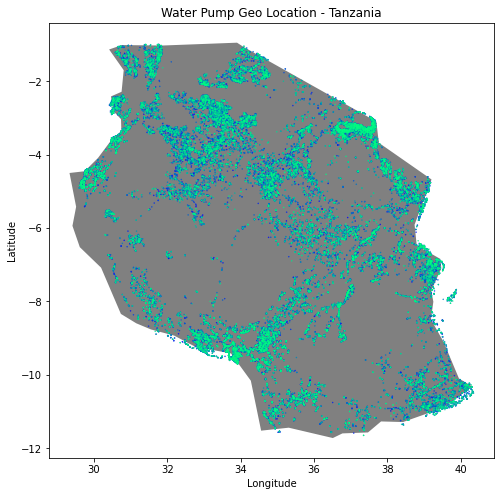

In [23]:
# Preparing the Geopandas Dataset
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'] )]
gdf = GeoDataFrame(long_lat, geometry = geometry)

# Selecting Tanzania
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
tanzania = world.loc[world['name'] == 'Tanzania'] 
boundaries = tanzania['geometry']

# Plotting - for this code I used several resources from Stack Overflow (https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6) 
# and the GeoPandas website
ax = tanzania.plot(figsize = (15, 8), color = 'gray')
gdf.plot(ax = ax, marker='o', markersize=0.2, cmap = 'winter')
ax.set_title('Water Pump Geo Location - Tanzania')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

In [24]:
# num_private - no clear description of the variable and full of zeros. I will drop it
df['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [25]:
# 70% of wells have no water available... this should be a strong predictor of not functioning
print(df['amount_tsh'].value_counts(normalize = True))

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64


In [26]:
# However, once we cross that date with quantity, it seems odd
df[['quantity', 'amount_tsh']]

,quantity,amount_tsh
id,,
69572,enough,6000.0
8776,insufficient,0.0
34310,enough,25.0
67743,dry,0.0
19728,seasonal,0.0
...,...,...
60739,enough,10.0
27263,enough,4700.0
37057,enough,0.0


In [27]:
# Checking amount_tsh - doesn't seem like a consistent predictor. The value is set to zero and has more
# than enough water...
print(df[df['amount_tsh'] == 0.0]['quantity'].value_counts(normalize = True))

# List of variables to be dropped
variable_drop = ['num_private', 'latitude', 'longitude', 'recorded_by', 'subvillage']

# Saving the original DataFrame
dfmap = df

# Dropping what I won't use. The variable recorded_by lists the name of the company that provided the dataset
df = df.drop(variable_drop, axis = 1)

enough          0.506809
insufficient    0.262110
dry             0.132472
seasonal        0.081918
unknown         0.016691
Name: quantity, dtype: float64


### Data Cleaning: Final Steps
The steps above indicate processes where I checked variable overlapping and some data cleansing procedures so we can start working with our models. First, I checked which variables had overlapping or similar values, such as: extraction_type, extraction_type_group, extraction_type_class, water_quality, quality_group, source_type, source_type_class and source_type_group.

Across the board, it is visible that some of these variables provide similar values with almost no different entry. By examining these columns, and dropping - following the logic depicted above - we are able to avoid multicollinearity of features.

I also examine the set of numerical variables from the dataset. From inspecting the columns, we see that num_private is filled with zeroes and will not provide much variation to our prediction. The construction number also has  considerable values set as zero (maybe missing?) and they certainly will need to be encoded as dummy variables. Population also does not provide too much useful information, as well as gps_height.

Furthermore, since this exercise will try to predict whether a pump is functioning or not, I substitute pumps categorized as 'functional needs repair' to 'functional'. The next steps will be encoding the categorical variables and scaling the numerical variables so we can work on a same scale.

In [28]:
# Splitting into numerical and categorical
numerical = ['amount_tsh', 'population', 'gps_height']
categorical = list(df.columns)

# Removing the numerical from categorical
for col in numerical:
    categorical.remove(col)
    
# Removing status_group from 'categorical'
categorical.remove('status_group')

## Machine Learning Framework
Over this next session, I start developing the Machine Learning (ML) framework. In order to estimate which model performs best, I start by guaranteeing all variables encoded are indeed strings. From there, I build a basic Decision Tree Classifier as the baseline model.

The general characteristics of all pipelines follow two steps before running the different models:
<ul>
    <li>Applying SimpleImputer to missing values;</li>
    <li>Applying a StandardScaler to numerical variables;</li>
    <li>Running OneHotEncoder to categorical/dummy variables.</li>
</ul>

All models are then run on a train-test split setting using a test size of 25%. Lastly, I evaluate the score of each model on training data and report their confusion matrices and classification report.

In [29]:
# Turning 'categorical' variables into strings
for var in list(df[categorical]):
    df[var] = df[var].astype('str')

# Generating Y's and X's
y = df['status_group']
X = df.drop('status_group', axis = 1)

# Train-Test-Split - test_size = 0.40 and random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [30]:
# Setting up basic data cleaning pipelines
num_pipeline = Pipeline(steps = [('ss', StandardScaler())])
cat_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                       ('ohe', OneHotEncoder(handle_unknown ='ignore'))])

# Now passing the ColumnTransformer
trans = ColumnTransformer(transformers = [('numerical', num_pipeline, X_train[numerical].columns), 
                                          ('categorical', cat_pipeline, X_train[categorical].columns)])

### Baseline Model: Logistic Regression
The baseline model to be tested is the Logistic Regression. Even though it seems like a simple model, it is quite robust and can provide good insights and results. The settings used are the most common ones. The score (accuracy) obtained by this model is starkingly close to 90% using the training data. 

By plotting the confusion matrix using the testing data set, it is clear that the model is consistent in categorizing whether a pump is or isn't functioning. The key takeaway from this modeling exercise is to discuss which metric should be the one sought off to minimize any adverse effects. More precisely, should the model tuning up focus on precision/accuracy, recall, f1-score or any other metric?

I posit that f1-score should be the most relevant and sought off metric. The rationale is as follows: while since false positives (a not functional water pump deemed as functional) or a false negative (a functional water pump categorized as not functioning) both have their costs to our stakeholders. 

We can imagine the situation of a person traveling (or avoiding to travel) for 3-5 miles to get water and facing a not functional water pump that was expected to function, or the other way around. Finally the classification report also allows for using different sets of rules versus the type of problem. The same example can be extended to maintenance companies, NGO's or public policy makers. So, a well balanced score, that takes Precision and Recall into account should be better suited, then F1 is our metric of choice. 

So to inspect the f1-score, I run a classification report on unseen, testing data. Its output shows the robustness of the model, with consistent metrics across the board. Since the main rationale argues for a balance between false positives and false negatives, the f1-score is the most importante metric.

The f1-score has an 87% (77%) consistency in predicting functional (not functional) pump status.

In [31]:
# Creating a LogisticRegression Pipeline
log_pipe = Pipeline(steps = [('trans', trans),
                         ('log', LogisticRegression(random_state = 42, solver = 'liblinear'))])
# Fitting our model
log_pipe.fit(X_train, y_train)
print('LogisticRegression Score:', round(log_pipe.score(X_train, y_train), 4))


LogisticRegression Score: 0.8956


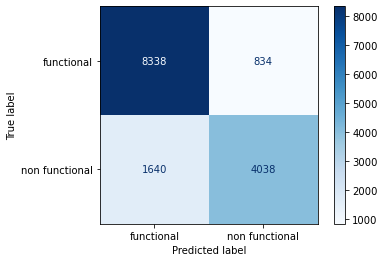

In [32]:
# Plotting the confusion matrix on Test Data
plot_confusion_matrix(log_pipe, X_test, y_test, cmap = plt.cm.Blues);

In [33]:
# Generating the predictions
y_pred = log_pipe.predict(X_test)

# Then printing the classification_report
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    functional       0.84      0.91      0.87      9172
non functional       0.83      0.71      0.77      5678

      accuracy                           0.83     14850
     macro avg       0.83      0.81      0.82     14850
  weighted avg       0.83      0.83      0.83     14850



### Baseline Model Concluding Remarks
The baseline model shows an accuracy of close to 90% when using training data. When using the same model with unseen data, we see a drop to its accuracy. I posit that focusing on accuracy solely won't provide us the best perspective in solving our business problem. 

Thus, when focusing on the f-1 score we can see the model is consistent in predicting whether pumps are functional or not. This exercise provides us a baseline comparison before I move on to more complex model and parameter tuning.

### Second Model: Decision Tree Classifier
The second model is a DecisionTreeClassifier. I run it with a random_state of 42, max_depth of 5 and the 'entropy' as the criterion. Overall, the model's score (accuracy) is 99% using the standard settings. However, this score does not yield our metric of interest, recall, the f1-score.

I also plot a confusion matrix which shows that the model is doing a reasonable job to predict whether a pump is functional or not (using testing data). It has a 87% (78%) consistency in predicting whether a pump is functional (not functional). 

One could question, how can these results be starkingly different? One thing is to have a given performance on training data (which it seems it is doing a pretty good job) and the other one is when we apply the same technique to unseen data. It could be the case that the model is overfitting our data, we will investigate this further under a cross validation approach within GridSearch.

In [34]:
# Starting pipeline process
dct_pipe = Pipeline(steps = [('trans', trans),
                         ('dct', DecisionTreeClassifier(random_state = 42))])

# Fitting our pipeline and retrieving the score                         
dct_pipe.fit(X_train, y_train)
print('DecisionTreeClassifier Score:', round(dct_pipe.score(X_train, y_train), 4))

DecisionTreeClassifier Score: 0.9986


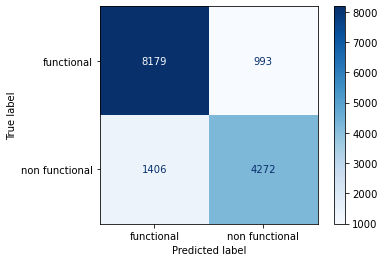

In [35]:
# Creating a confusing matrix to check the consistency of the model with testing data
plot_confusion_matrix(dct_pipe, X_test, y_test, cmap = plt.cm.Blues);

In [36]:
# Generating the predictions
y_pred_dct = dct_pipe.predict(X_test)

# Then printing the classification_report
print(classification_report(y_test, y_pred_dct))

                precision    recall  f1-score   support

    functional       0.85      0.89      0.87      9172
non functional       0.81      0.75      0.78      5678

      accuracy                           0.84     14850
     macro avg       0.83      0.82      0.83     14850
  weighted avg       0.84      0.84      0.84     14850



### Third Model: Random Forest Classifier
Lastly, I create a RandomForestClassifier pipeline. The process is the same one as the other two models before, we start the pipeline by imputing values with the SimpleImputer, then we encode the categorical variables through OneHotEncoder and then we fit and score the model.

The score is quite impressive, close to 'perfection' to fit the training data. A whopping 99% might seem as a good indicative of the quality of this model, but it doesn't work that way. Clearly the RandomForestClassifier is overfitting our data and this becomes our point of attention as we progress with the estimation of this model.

The confusion matrix and classification report provide some exciting results. Across the board, all the metrics have very promising scores, whether they are precision, recall or even f1-score. The values range from 75-92%.

Even though promising, we should take this information with a grain of salt. At the end of this exercise, I will run those processes on testing data using cross validation folds and check their consistency.


In [37]:
# Let's try a more sophisticated model by creating a new pipeline - RandomForestClassifier
rf_pipe = Pipeline(steps = [('trans', trans), 
                         ('rft', RandomForestClassifier(random_state = 42))])

# Fitting and scoring our new pipe
rf_pipe.fit(X_train, y_train)
print('RandomForestClassifier Score:', round(rf_pipe.score(X_train, y_train),4))

RandomForestClassifier Score: 0.9986


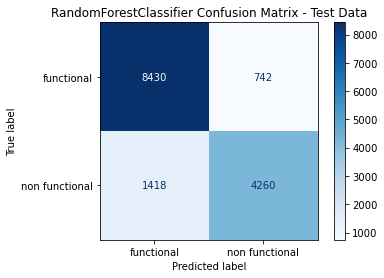

In [38]:
# Creating a confusing matrix to check the consistency of the model
plot_confusion_matrix(rf_pipe, X_test, y_test, cmap = plt.cm.Blues).ax_.set_title('RandomForestClassifier Confusion Matrix - Test Data');

In [39]:
# Generating the predictions
y_pred_rf = rf_pipe.predict(X_test)

# Then printing the classification_report
print(classification_report(y_test, y_pred_rf))

                precision    recall  f1-score   support

    functional       0.86      0.92      0.89      9172
non functional       0.85      0.75      0.80      5678

      accuracy                           0.85     14850
     macro avg       0.85      0.83      0.84     14850
  weighted avg       0.85      0.85      0.85     14850



### Hyperparameter tunning
Having run three models, it is shown that both DecisionTreeClassifier and RandomForestsClassifer model provide robusts results compared with the naive baseline model. The next step will focus on hyperparameter tunning, searching for the optimal combination that will provide the best accuracy (score) without overfitting the data.

For both the DecisionTreeClassifier and the RandomForest models, I set up a GridSearchCV (i.e. grid search with cross validation) using basic parameters. Due to computing limitations other complex parameter tunning is not available, so the reader might use this exercise as a guideline for further data finnicking.

#### DecisionTreeClassifier tunning
I start the GridSearch trying to find the best combination of criterion, max_depth, min_samples_leaf and min_samples_split on training data. The scoring method is default one, accuracy. The best combination of hyperparameters is to use the gini criterion, with None max_depth, 1 min_samples_leaf and a min_samples_split of 2. The best score is 82.69% under three cross-validation folds.

In [40]:
# Building a GridSearchCV framework - DecisionTreeClassifier (dct)
param_grid = {
    'dct__criterion': ['gini', 'entropy'],
    'dct__max_depth': [None, 3, 5, 15],
    'dct__min_samples_leaf': [1, 3, 9],
    'dct__min_samples_split': [2, 5, 10, 15]
}

# Instantiating the GridSearch
grid_search = GridSearchCV(dct_pipe, param_grid = param_grid, cv = 3, n_jobs = -1)

# Fitting to our data
grid_search.fit(X_train, y_train)

# Printing out the Results
print(f"Best Score: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

Best Score: 82.69%

Optimal Parameters: {'dct__criterion': 'gini', 'dct__max_depth': None, 'dct__min_samples_leaf': 1, 'dct__min_samples_split': 2}


#### RandomForestClassifier tunning
Using a cross-validation fold of 3 and still aiming for the best accuracy, I now tune the hyperparameters for the RandomForestClassifier model. The hyperparameters are the criterion, max_depth, min_samples_leaf, max_leaf_nodes and min_samples_split.

This model is marginally superior to the last one, achieving the best score of almost 85.12%. The combination of hyperparameters that yields the best result is a criterion gini, max_depth of None, min_samples_leaf as 1 and min_samples_split of 5 while max_leaf_nodes is None. I will select this model as the best one given its performance - even though the DecisionTreeClassifier also had a good score, albeit is marginally inferior result.

In [41]:
# Creating a new GridSearchCV framework - RandomForest (rft)
rf_param_grid = {
    'rft__criterion': ['gini', 'entropy'],
    'rft__max_depth': [None, 3, 7],
    'rft__min_samples_leaf': [1, 3, 6],
    'rft__min_samples_split': [2, 5, 10],
    'rft__max_leaf_nodes': [None, 5, 10, 20]
}

# Instantiating the GridSearch
rf_grid_search = GridSearchCV(rf_pipe, rf_param_grid, cv = 3, n_jobs = -1)

# Fitting to our data
rf_grid_search.fit(X_train, y_train)

# Printing out the Results
print(f"Best Score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Best Score: 85.12%

Optimal Parameters: {'rft__criterion': 'gini', 'rft__max_depth': None, 'rft__max_leaf_nodes': None, 'rft__min_samples_leaf': 1, 'rft__min_samples_split': 5}


## The Final Assessment: scoring our models on testing data
The models above have done their jobs using training data. However, how well do they fare when facing unseen data? I am going to be addressed it in this section.

Ideally, a model would have a great a good balancing with training and testing data, i.e. good performance with the different data sets. The whole point of prediction is to see how good your model can deal with new, unseen data. I generate scores of the three models used: LogisticRegression, DecisionTreeClassifier, and RandomForestClassifier on testing data.

The result shows the robustness of the RandomForestClassifier approach. Its f1-score is 89%, shying away a few percentage points from its run on testing data. Second, we have the DecisionTreeClassifier, with also a good score of 87%. Finally, the LogisticRegression has an almost similar score to the DecisionTree one, which leads to the conclusion that all the presented alternatives are consistent in predicting the status of wells.

Logically, I will continue working using the RandomForestClassifier to extract the best features that allows us to predict whether a water pump is functional or not. To wit, these results are run on just one fold, so it is advised to estimate its robustness using more folds - since these results could be given by sheer randomness. This is what I will do next.

In [42]:
# Separating for plots
model_a = round(f1_score(y_test, y_pred, average = 'binary', pos_label = 'functional'), 3)
model_b = round(f1_score(y_test, y_pred_dct, average = 'binary', pos_label = 'functional'), 3)
model_c = round(f1_score(y_test, y_pred_rf, average = 'binary', pos_label = 'functional'), 3)

# Final Scores
print('Logistic Regression (baseline):', model_a)
print('DecisionTree Grid Search:', model_b)
print('RandomForest Grid Search:', model_c)

Logistic Regression (baseline): 0.871
DecisionTree Grid Search: 0.872
RandomForest Grid Search: 0.886


### Running GridSearchCV maximizing the f1_score
Previously the GridSearch runs were maximizing the accuracy metric. It was clear that under three cross validation folds, the overfitting issue was solved. Now, to check whether these models are indeed the most appropriate to the task, I will run them using the cross validation folds and in combination with their best parameters to check their consistency of the f1-score.

The DecisionTreeClassifier model has a f1-score of 82.56%, whereas the RandomForestClassifier has a 84.78% performance. Indicating its superiority also as the best model to maximize the f1-score and not only the accuracy.

In [43]:
# Now running GridSearchCV with scoring as f1 (dct)
param_grid = {
    'dct__criterion': ['gini'],
    'dct__max_depth': [None],
    'dct__min_samples_leaf': [1],
    'dct__min_samples_split': [2]
}

# Instantiating the GridSearch
grid_search = GridSearchCV(dct_pipe, param_grid = param_grid, cv = 3, scoring = 'f1_weighted', n_jobs = -1)

# Fitting to our data
grid_search.fit(X_train, y_train)

# Printing out the Results
print(f"Best Score: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

Best Score: 82.56%

Optimal Parameters: {'dct__criterion': 'gini', 'dct__max_depth': None, 'dct__min_samples_leaf': 1, 'dct__min_samples_split': 2}


In [44]:
# Now running GridSearchCV with scoring as f1 (random_forest)
rf_param_grid = {
    'rft__criterion': ['entropy'],
    'rft__max_depth': [None],
    'rft__min_samples_leaf': [1],
    'rft__min_samples_split': [5],
    'rft__max_leaf_nodes': [None]
}

# Instantiating the GridSearch
rf_grid_search = GridSearchCV(rf_pipe, rf_param_grid, cv = 3, scoring = 'f1_weighted', n_jobs = -1)

# Fitting to our data
rf_grid_search.fit(X_train, y_train)

# Printing out the Results
print(f"Best Score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Best Score: 84.78%

Optimal Parameters: {'rft__criterion': 'entropy', 'rft__max_depth': None, 'rft__max_leaf_nodes': None, 'rft__min_samples_leaf': 1, 'rft__min_samples_split': 5}


### But which variables are the most relevant ones?
The RandomForestClassifier was the best model, however which features are the most relevant ones for the model's performance? The next section is dedicated to this exercise. Below, I run the RandomForestClassifier model once again and list its most relevant features. 

On this run, I'll be using the set of best hyperparameters as illustrated by the GridSearchCV above. The figure below indicates the most relevant features in predicting whether a pump is functional or not are (from most important to least):
<ul>
    <li><b>funder</b>: who funded the well;</li>
    <li><b>date_recorded</b>: the date the observation was recorded;</li>
    <li><b>amount_tsh</b>: the amount of water available to waterpoint.</li>
</ul>

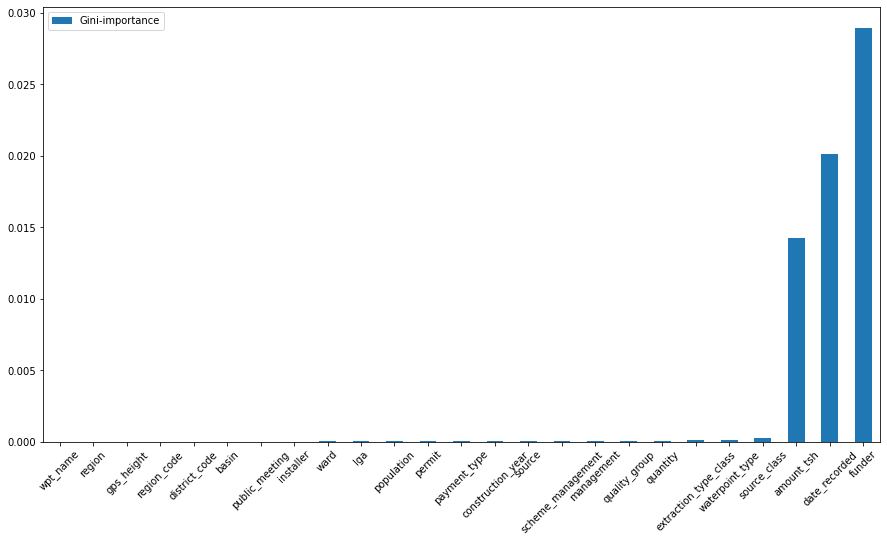

In [45]:
# Final Pipeline with the best parameters
final = Pipeline(steps = [('trans', trans), 
                          ('rft', RandomForestClassifier(random_state = 42, criterion = 'gini', min_samples_leaf = 1, min_samples_split = 5))])

# Fitting once again
final.fit(X_train, y_train)

# Retrieving the feature importances
importances = final.named_steps['rft'].feature_importances_

# This portion of the code was adapted from StackOverflow
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, importances):
    feats[feature] = importance #add the name/value pair 

# Setting new DataFrame
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45, figsize = (15, 8));

## Concluding Remarks and Recommendations
By following our Machine Learning workflow, we were able to inspect that the best performing model is the RandomForestClassifier. The model has an f1-score of 89% (85% using CV equal to 3) on unseen data. Fortunately, the model doesn't shy away from the standard configuration, with little to no tuning necessary. The model beats the performance of both the LogisticRegression and DecisionTreeClassifier - even though both of these models also provide good performance.

Due to computational limitations, some hyperparameter tunning were not run - so it could be some future development to be performed. The most relevant features from the model are: funder, date_recorded and amount_tsh. The funder is the agent that funded the well, whereas date_recorded lists the date that the information was inserted. Lastly, amount_tsh indicates the amount of water available.

In practical terms, what could be the output of the model in a real life situation? With the code below I plot Tanzania's map with respect to each water pump's status. By visually splitting between 'Functional' and 'Not Functional' we can have a more insightful approach.

It was clear before that water pumps are almost evenly split between functioning and not functioning. It seems to be the case that they 'look like' to be evenly spread across the map as well. So suppose one of the groups of interest that we have discussed before would like to perform prophylactic maintenance to pumps.

By using the algorithm, it would be able to almost accurately predict whether that pump is functioning or not but using the model with the features aboves. Furthermore, from the map below it is also clear that are some regions that lack pumps, whether they are functioning or not - and maybe that could be also an approach to diminish traveling time to get to water.


In [46]:
# Preparing the Geopandas Dataset
dfmap = dfmap[(dfmap['longitude'] != 0) & (dfmap['latitude'] != 0)]

# Encoding Functional and Not Functional
dfmap['status_group'] = [1 if x == 'functional' else 0 for x in dfmap['status_group']]

# Filtering for Functional and Not Funcional
func = dfmap[dfmap['status_group'] == 1]
not_func = dfmap[dfmap['status_group'] == 0]

geo_func = [Point(xy) for xy in zip(func['longitude'], func['latitude'])]
geo_nfunc = [Point(xy) for xy in zip(not_func['longitude'], not_func['latitude'])]

# Adding the Water Pump Status
func = GeoDataFrame(func, geometry = geo_func)
not_func = GeoDataFrame(not_func, geometry = geo_nfunc)

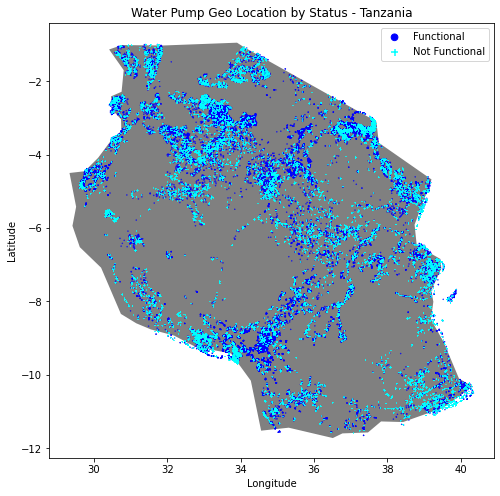

In [47]:
# Now the Final Graph
ax = tanzania.plot(figsize = (15, 8), color = 'gray')
func.plot(column = 'status_group', marker ='o', markersize = 0.2, cmap = 'winter', ax = ax)
not_func.plot(column = 'status_group', marker = '+', markersize = 0.2, cmap = 'cool', ax = ax)
ax.legend(['Functional', 'Not Functional'], markerscale = 15)
ax.set_title('Water Pump Geo Location by Status - Tanzania')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');
